In [2]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from importlib import reload  # Python 3.4+

from sklearn import metrics
import seaborn as sns
sns.set()

from sklearn.calibration import CalibratedClassifierCV

from IPython.display import clear_output, display

In [3]:
train_df = pd.read_csv('train_processed_data_for_2012.csv')
train_df.shape

(226234, 72)

In [6]:
test_df = pd.read_csv('test_processed_data_for_2012.csv')
test_df.shape

(185639, 72)

In [8]:
train_df['stmt_date'] = pd.to_datetime(train_df['stmt_date'])
train_df['def_date'] = pd.to_datetime(train_df['def_date'])
train_df.sort_values('stmt_date', inplace=True)

test_df['stmt_date'] = pd.to_datetime(test_df['stmt_date'])
test_df['def_date'] = pd.to_datetime(test_df['def_date'])
test_df.sort_values('stmt_date', inplace=True)

## Train algorithm

In [11]:
### features for first firm
features = [
    'asst_tot_quantile_values',
    'financial_leverage_quantile_values',
    'profitability_ratio_quantile_values',
    # 'net_income_growth_quantile_values',
    'quick_ratio_v2_quantile_values',
    # 'sales_growth_quantile_values',
    'cash_assets_ratio_quantile_values',
    'dscr_quantile_values',
    # 'ebitda',
]


In [12]:
### features for recurring firms
rec_features = [
    'asst_tot_quantile_values',
    'financial_leverage_quantile_values',
    'profitability_ratio_quantile_values',
    'net_income_growth_quantile_values',
    'quick_ratio_v2_quantile_values',
    'sales_growth_quantile_values',
    'cash_assets_ratio_quantile_values',
    'dscr_quantile_values',
    # 'ebitda',

]

In [13]:
formula = 'default ~ '+' + '.join(features)
#formula = 'default ~ '+' + '.join(rec_features)
formula

'default ~ asst_tot_quantile_values + financial_leverage_quantile_values + profitability_ratio_quantile_values + quick_ratio_v2_quantile_values + cash_assets_ratio_quantile_values + dscr_quantile_values'

In [14]:
algo = smf.probit

model = algo(formula, data = train_df) 
fitted_model = model.fit()

Optimization terminated successfully.
         Current function value: 0.048469
         Iterations 9


### Model results

In [15]:
print(fitted_model.summary())

                          Probit Regression Results                           
Dep. Variable:                default   No. Observations:               226234
Model:                         Probit   Df Residuals:                   226227
Method:                           MLE   Df Model:                            6
Date:                Mon, 11 Nov 2024   Pseudo R-squ.:                  0.2022
Time:                        18:42:07   Log-Likelihood:                -10965.
converged:                       True   LL-Null:                       -13745.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -3.7332      0.090    -41.303      0.000      -3.910      -3.556
asst_tot_quantile_values               24.1184      5.63

In [16]:
print(fitted_model.get_margeff().summary())

       Probit Marginal Effects       
Dep. Variable:                default
Method:                          dydx
At:                           overall
                                         dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
asst_tot_quantile_values                0.5660      0.133      4.271      0.000       0.306       0.826
financial_leverage_quantile_values      0.0580      0.004     14.522      0.000       0.050       0.066
profitability_ratio_quantile_values     0.1100      0.005     24.375      0.000       0.101       0.119
quick_ratio_v2_quantile_values          0.4801      0.040     11.968      0.000       0.402       0.559
cash_assets_ratio_quantile_values       0.6796      0.070      9.758      0.000       0.543       0.816
dscr_quantile_values                    0.2698      0.011     24.359      0.000       0.248       0.291


## Process test data

In [19]:
test_predictions = fitted_model.predict(test_df)

In [21]:
test_results = test_df[['default']].copy()
test_results['predictions'] = test_predictions

In [22]:
test_results.head()

,default,predictions
0,0,0.079468
123754,0,0.047258
123755,0,0.020898
123756,0,0.004824
123757,0,0.004481


In [23]:
metrics.roc_auc_score(y_score=test_results['predictions'], y_true=test_results['default'])

np.float64(0.8213539187657071)

ROC AUC 0.8213539187657071


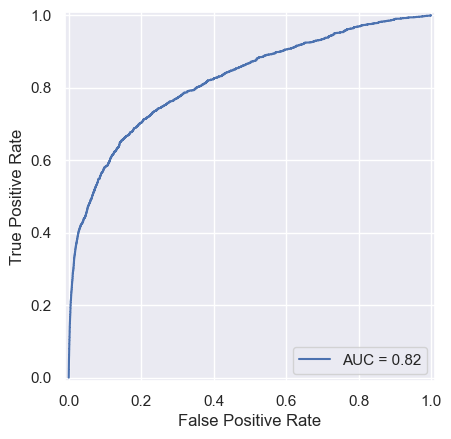

In [24]:
fpr, tpr, thresholds = metrics.roc_curve(test_results['default'], test_results['predictions'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()